# Homework 2
## IDS 576 <br>
Name: Isaac Salvador <br>
Email: isalva2@uic.edu <br>
UIN: 6669845132 <br>

Name: Ahreum Kim <br>
Email: akim239@uic.edu <br>
UIN: 653241895 <br>

please add your information here

## 1. CNNs and finetuning


### Download the CIFAR 10 dataset (original data can be found [here](http://www.cs.toronto.edu/~kriz/cifar.html), and here is a link to the  pickled [python version](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).)

First we specify some data augmentations with [Transforms V2](https://pytorch.org/vision/stable/auto_examples/plot_transforms_v2.html) for both the training and testing sets. The following transforms are applied to the `train_transform` object:

- `RandomRotation`: Rotates the image between 0 and 30 degrees
  
- `RandomHorizontalFlip`: Randomly flips an image along the horizontal axis
  
- `ToImageTensor`: transforms input image into a `torch.Tensor`
  
- `ConvertImageDtype`: converts elements in tensors to `float32` dtype – necessary for development on M-series MacBooks.
  
- `Normalize`: Normalize tensor values such that the mean and standard deviation of the images become `0.0` and `1.0` respectively. Per-color mean and standard deviation values were calculated w.r.t. this [guide](https://saturncloud.io/blog/how-to-normalize-pytorch-cifar10-images-for-improved-model-performance/).

We instantiate an `unaugmented_transform` object as well to create test and validation validation datasets without any augmentations.

In [2]:
import torch
from torch import mps
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

# make torch deterministic for reproducibility
torch.manual_seed(576)

# previously calculated normalization values
mean = [0.4934569299, 0.483376652, 0.4471793473]
std = [0.2476211786, 0.2445851415, 0.2626110017]

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

unaugmented_transform = transforms.Compose(
    [
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

We next download the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) from the pytorch website and apply the transforms. The `unaugumented_set` is 50/50 split into a `test_set` and `val_set` using the `random_split` utility.

In [11]:
import torchvision.datasets as datasets
from torch.utils.data import random_split

train_set = datasets.CIFAR10("./Misc_files/data", train=True, transform=train_transform, download=True)

unaugmented_set = datasets.CIFAR10("./Misc_files/data", train=False, transform=unaugmented_transform, download=True)

test_set, val_set = random_split(unaugmented_set, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


The train, test, and validation sets are then passed to a `Dataloader` iterable with a common practice `batch_size` of 32:

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_set, batch_size = 32, shuffle=True)

With the datasets finalized we can additionally view some sample instances of the data. Plotting instances of the training set can additionally show the results of of the data augmentations (`RandomRotation` is apparent).

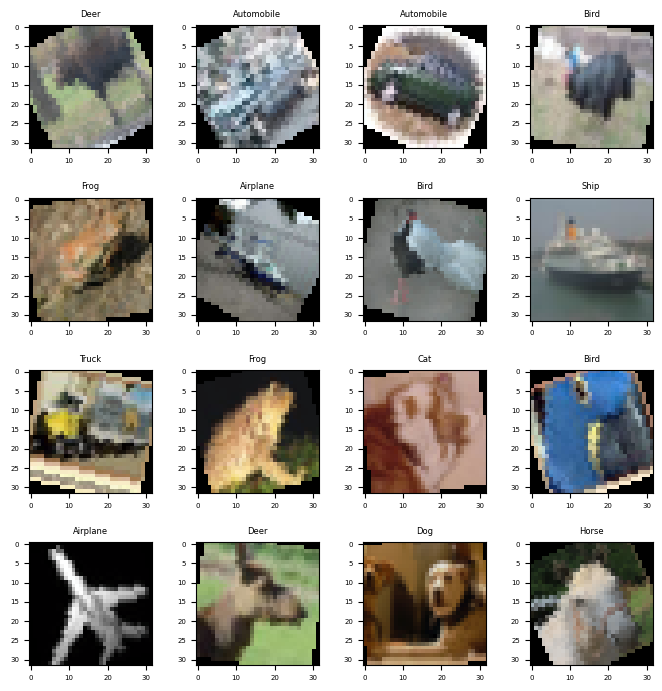

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

CIFAR10_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

images, labels = next(iter(train_loader))

# Define plot size and DPI
fig = plt.figure(figsize=(8, 8), dpi=100)

# Adjust space between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(CIFAR10_labels.get(int(labels[i])))
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1.)
    plt.imshow(img)

plt.show()

Use the pretrained Resnet18 model (from trochvision) to extract features. Use the features as inputs in a new multi-class logistic regression model (use nn.Linear/ nn.Module to define your model)
	 -(a) Describe any choices made and report test performance.
	 -(b) Display the top 5 correct predictions and the top 5 incorrect predictions in each class (show the images and the prediction labels) compactly.

Finetune the Resnet18 model's parameters suitably and repeat parts (a) and (b) from above. Compare the performance of finetuning versus using extracted features.

## 2. Movie embeddings


Instead of embedding words, we will embed movies.  In particular, if we can embed movies, then similar movies will be close to each other and can be recommended.  This line of reasoning  is analogous to the [distributional hypothesis of word meanings](https://en.wikipedia.org/wiki/Distributional_semantics). For words, this roughly translates to words that appear in similar sentences should have similar vector representations. For movies, vectors for two movies should be similar if they are watched by similar people.

Let the total number of movies be $M$. Let $X_{i,j}$ be the number of users that liked both movies $i$ and $j$. We want to obtain vectors $v_1,...,v_i,...,v_j,...,v_M$ for all movies such that we minimize the cost $c(v_1,...,v_M) = \sum_{i=1}^{M}\sum_{j=1}^{M}\mathbf{1}_{[i\neq j]}(v_i^Tv_j - X_{i,j})^2$. Here $\mathbf{1}_{[i\neq j]}$ is a function that is $0$ when $i=j$ and $1$ otherwise.

Compute data $X_{i,j}$ from the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip). You can also download using the link to `ml-latest-small.zip` from this [page](https://grouplens.org/datasets/movielens/) (be sure to read the corresponding [description](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)). Briefly describe your data prep workflow (you can use `pandas` if needed).

Optimize function $c(v_1,...,v_M)$ over $v_1,...,v_M$ using gradient descent (using `pytorch` or `tensorflow`). Plot the loss as a function of iteration for various choices (learning rates, choice of optimizers etc).

Recommend top 10 movies (not vectors or indices but movie names) given movies (a) _Apollo 13_, (b) _Toy Story_, and (c) _Home Alone_ . Describe your recommendation strategy. Do the recommendations change when you change learning rates or optimizers? Why or why not?